In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import community as community_louvain
import tqdm
import torch
from torch import nn

from model.tgn import TGN
from utils.data_processing import get_data, compute_time_statistics
from utils.utils import EarlyStopMonitor, RandEdgeSampler, get_neighbor_finder
from evaluation.evaluation import eval_edge_prediction, eval_anomaly
from sklearn import manifold
from sklearn.decomposition import PCA
from pathlib import Path
from sklearn import metrics

## Download model and data

### Data

In [2]:
data_set = "Synthetic"

### Extract data for training, validation and testing
node_features, edge_features, full_data, train_data, val_data, test_data, new_node_val_data, \
new_node_test_data = get_data(data_set) #, randomize_features=True)

# Initialize training neighbor finder to retrieve temporal graph
train_ngh_finder = get_neighbor_finder(train_data, False)

# Initialize validation and test neighbor finder to retrieve temporal graph
full_ngh_finder = get_neighbor_finder(full_data, False)

(2001, 172)
The dataset has 21324 interactions, involving 2000 different nodes
The training dataset has 12097 interactions, involving 1791 different nodes
The validation dataset has 3198 interactions, involving 1656 different nodes
The test dataset has 3199 interactions, involving 1639 different nodes
The new node validation dataset has 614 interactions, involving 654 different nodes
The new node test dataset has 645 interactions, involving 653 different nodes
200 nodes were used for the inductive testing, i.e. are never seen during training


### Parameters

In [3]:
# Compute time statistics
mean_time_shift_src, std_time_shift_src, mean_time_shift_dst, std_time_shift_dst = \
  compute_time_statistics(full_data.sources, full_data.destinations, full_data.timestamps)

NUM_LAYER = 1
NUM_HEADS = 2
DROP_OUT = 0.1
USE_MEMORY = True
MESSAGE_DIM = 100
MEMORY_DIM = 172
NUM_NEIGHBORS = 10

### Model

In [4]:
model = TGN(neighbor_finder=full_ngh_finder, node_features=node_features,
            edge_features=edge_features, device='cpu',
            n_layers=NUM_LAYER,
            n_heads=NUM_HEADS, dropout=DROP_OUT, use_memory=USE_MEMORY,
            message_dimension=MESSAGE_DIM, memory_dimension=MEMORY_DIM,
            memory_update_at_start= True,
            embedding_module_type='graph_attention',
            message_function='identity',
            aggregator_type='last',
            memory_updater_type='gru',
            n_neighbors=NUM_NEIGHBORS,
            mean_time_shift_src=mean_time_shift_src, std_time_shift_src=std_time_shift_src,
            mean_time_shift_dst=mean_time_shift_dst, std_time_shift_dst=std_time_shift_dst,
            use_destination_embedding_in_message=False,
            use_source_embedding_in_message=False,
            dyrep=False)
model.load_state_dict(torch.load(f'saved_models/tgn-attn-{data_set}.pth', map_location=torch.device('cpu')))
model.eval()

TGN(
  (time_encoder): TimeEncode(
    (w): Linear(in_features=1, out_features=172, bias=True)
  )
  (memory): Memory()
  (message_aggregator): LastMessageAggregator()
  (message_function): IdentityMessageFunction()
  (memory_updater): GRUMemoryUpdater(
    (memory): Memory()
    (layer_norm): LayerNorm((172,), eps=1e-05, elementwise_affine=True)
    (memory_updater): GRUCell(685, 172)
  )
  (embedding_module): GraphAttentionEmbedding(
    (time_encoder): TimeEncode(
      (w): Linear(in_features=1, out_features=172, bias=True)
    )
    (attention_models): ModuleList(
      (0): TemporalAttentionLayer(
        (merger): MergeLayer(
          (fc1): Linear(in_features=516, out_features=172, bias=True)
          (fc2): Linear(in_features=172, out_features=172, bias=True)
          (act): ReLU()
        )
        (multi_head_target): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=344, out_features=344, bias=True)
        )
      )
    )
  )
  (affin

## Anomaly scores computation

In [5]:
model.memory.__init_memory__()
model.set_neighbor_finder(full_ngh_finder)
nodes = np.unique(np.hstack((full_data.sources,full_data.destinations)))

anomaly_scores = eval_anomaly(model, full_data, NUM_NEIGHBORS, batch_size = 200)

## Results

In [6]:
# Indices of abnormal edges

if Path(f'./data/anom_edges/{data_set}_anom_edges.csv').is_file():
    anom_edges = pd.read_csv(f'./data/anom_edges/{data_set}_anom_edges.csv').to_numpy().T[0]
    
# Snap times for comparison with TADDY

if Path(f'./data/snaps/{data_set}_snaps.csv').is_file():
    snaps_indices = pd.read_csv(f'./data/snaps/{data_set}_snaps.csv').to_numpy().T[0]
else:
    snaps_indices = np.array([0, len(full_data.sources)])

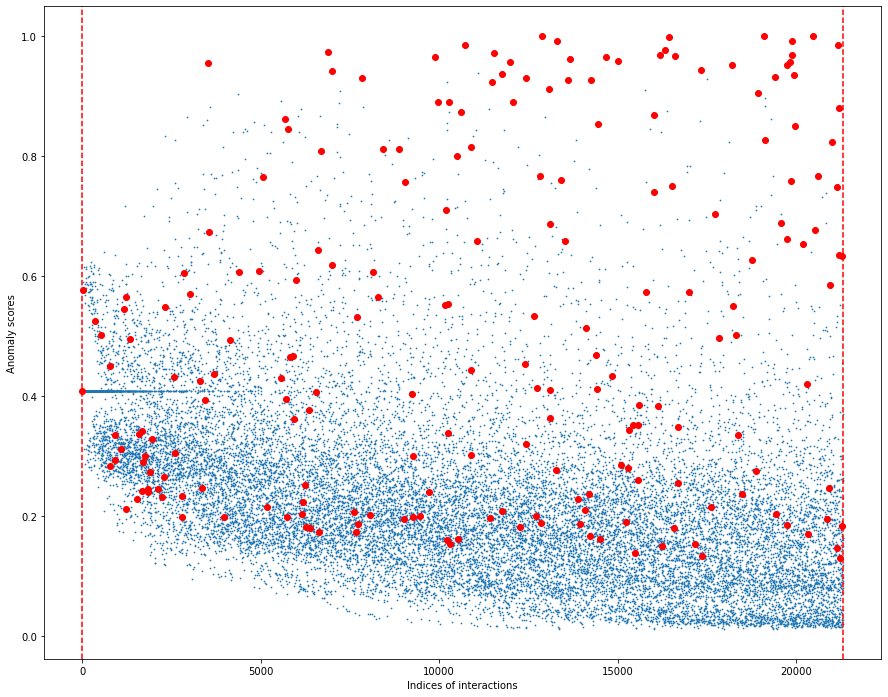

AUC - snap  0  :  0.8068328109430569
Total AUC (on the test set) :  0.8068328109430569


In [12]:
plt.figure(figsize=(15,12))
plt.scatter(np.arange(len(full_data.sources)), anomaly_scores, s=0.5)
for edge in anom_edges:
    plt.scatter(edge, anomaly_scores[edge], c='red')
for snap in snaps_indices:
    plt.axvline(x=snap, color='red', linestyle='--')
plt.xlabel('Indices of interactions')
plt.ylabel("Anomaly scores")
plt.show()

for i in range(len(snaps_indices)-1):
    y_test = np.zeros(int(snaps_indices[i+1]-snaps_indices[i]))
    for edge in anom_edges:
        if snaps_indices[i] <= edge and edge <= snaps_indices[i+1]:
            y_test[edge-snaps_indices[i]] = 1
    auc = metrics.roc_auc_score(y_test, anomaly_scores[snaps_indices[i]:snaps_indices[i+1]])
    print("AUC - snap ", i, " : ", auc)

y_test = np.zeros(len(full_data.sources)-snaps_indices[0])
y_test[np.array(anom_edges)-snaps_indices[0]] = 1
auc = metrics.roc_auc_score(y_test, anomaly_scores[snaps_indices[0]:])
print("Total AUC (on the test set) : ", auc)